## **Check GPU**

In [43]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [44]:
# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.14.0-dev20230620
Notebook last run (end-to-end): 2023-07-17 10:41:35.283250


## **Get helper functions**

In [45]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")


[INFO] 'helper_functions.py' already exists, skipping download.


## **Download Kaggle dataset**

In [46]:
import opendatasets as od
import pandas as pd

In [47]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/saloni1712/chatgpt-app-reviews")

Skipping, found downloaded files in ".\chatgpt-app-reviews" (use force=True to force download)


In [48]:
data = pd.read_csv('C:/Users/Nima/Desktop/ChatGPT_Reviews/chatgpt-app-reviews/chatgpt_reviews.csv')

In [49]:
data.shape

(2058, 4)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2058 non-null   object
 1   title   2058 non-null   object
 2   review  2058 non-null   object
 3   rating  2058 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.4+ KB


In [51]:
data.describe()

,rating
count,2058.000000
mean,3.744898
std,1.577841
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [52]:
data.describe(include='object')

,date,title,review
count,2058,2058,2058
unique,2053,1850,2033
top,2023-05-18 23:04:43,Finally,First
freq,2,13,5


## **Analysis of Rating column**

In [53]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1     391
2     115
3     199
4     276
5    1077
Name: rating, dtype: int64

In [54]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    19.00
2     5.59
3     9.67
4    13.41
5    52.33
Name: rating, dtype: float64

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

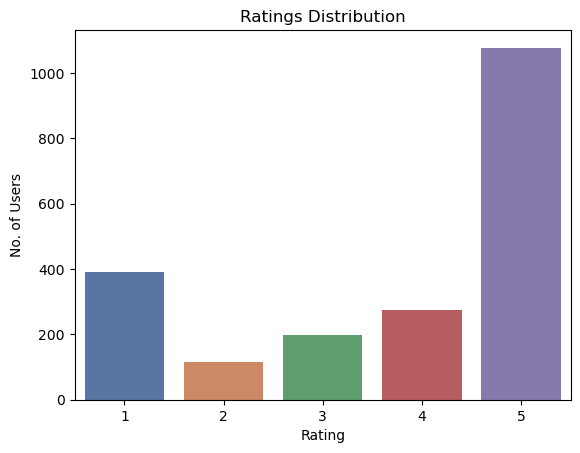

In [56]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

## **Data Preprocessing**

In [57]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [58]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [59]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [60]:
data.head()

,rating,complete_review
0,4,Much more accessible for blind users than the ...
1,4,"4.5 stars, here’s why .I recently downloaded t..."
2,4,"Almost 5 stars, but… no search function .This ..."
3,4,"Good, but Siri support would take it to the ne..."
4,1,"App review .No doubt, this technology is absol..."


#### **Convert all the reviews to lowercase**

In [61]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    much more accessible for blind users than the ...
1    4.5 stars, here’s why .i recently downloaded t...
2    almost 5 stars, but… no search function .this ...
3    good, but siri support would take it to the ne...
4    app review .no doubt, this technology is absol...
Name: complete_review, dtype: object

#### **Remove Punctuation**

In [62]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

#### **Remove Emojis**

In [63]:
import re

In [64]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

#### **Remove Stopwords**

In [65]:
# Instal spaCy: https://spacy.io/usage
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Using cached pip-23.2-py3-none-any.whl (2.1 MB)
  Using cached setuptools-68.0.0-py3-none-any.whl (804 kB)
  Using cached wheel-0.40.0-py3-none-any.whl (64 kB)


ERROR: To modify pip, please run the following command:
C:\Users\Nima\anaconda3\envs\tensorflow_python_3_10\python.exe -m pip install -U pip setuptools wheel


                                              0.0/12.8 MB ? eta -:--:--
                                             0.0/12.8 MB 960.0 kB/s eta 0:00:14
                                              0.1/12.8 MB 1.3 MB/s eta 0:00:10
                                              0.2/12.8 MB 1.5 MB/s eta 0:00:09
                                              0.3/12.8 MB 1.7 MB/s eta 0:00:08
     -                                        0.4/12.8 MB 1.9 MB/s eta 0:00:07
     -                                        0.5/12.8 MB 2.0 MB/s eta 0:00:06
     -                                        0.6/12.8 MB 2.1 MB/s eta 0:00:06
     --                                       0.7/12.8 MB 2.1 MB/s eta 0:00:06
     --                                       0.9/12.8 MB 2.2 MB/s eta 0:00:06
     ---                                      1.0/12.8 MB 2.2 MB/s eta 0:00:06
     ---                                      1.1/12.8 MB 2.3 MB/s eta 0:00:05
     ---                                      1.3/12.8 MB 

In [66]:
import nltk
from nltk.corpus import stopwords
import spacy

In [67]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
# nlp = spacy.load('en_core_web_sm')

In [69]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [70]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### **Apply Lemmatization**

In [71]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

#### **Remove certain words**

In [72]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

#### **Map ratings to positive, negative & neutral sentiment**

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [73]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,4,much accessible blind user web version point I...,2
1,4,45 star here recently download overall great p...,2
2,4,almost 5 star search function would almost per...,2
3,4,good siri support would take next level apprec...,2
4,1,review doubt technology absolutely lifechange ...,0


In [74]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    65.74
0    24.59
1     9.67
Name: sentiment, dtype: float64

## **Reviews Analysis**

In [75]:
!pip install wordcloud

In [76]:
from wordcloud import WordCloud, STOPWORDS

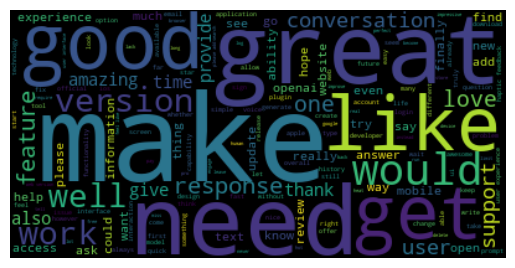

In [77]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [78]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

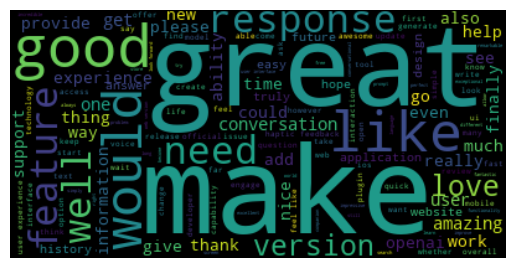

In [79]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

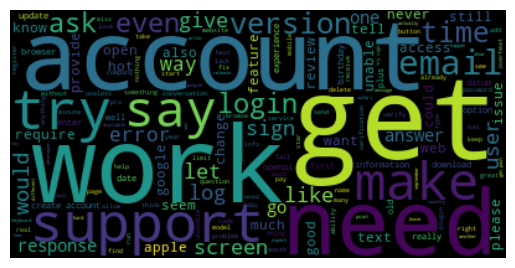

In [80]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

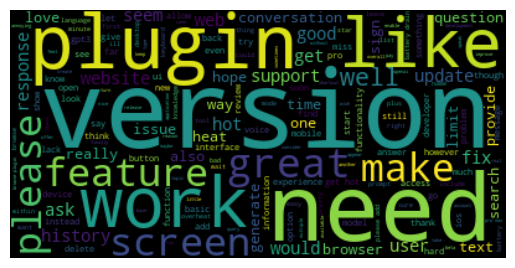

In [81]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Sentiment Analysis Model**

#### **Bag of Word Vectorization**

In [82]:
# from nltk.tokenize import RegexpTokenizer
# from sklearn.feature_extraction.text import CountVectorizer

In [83]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
# token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
# X = cv.fit_transform(data['complete_review'])
# y = data['sentiment']

#### **Handle Imbalanced Data**

In [84]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

In [85]:
# Instantiate the SMOTE object
# smote = SMOTE()

# Perform oversampling
# X_oversampled, y_oversampled = smote.fit_resample(X, y)

#### **Train Test Split**

In [86]:
#Train Test split
# X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
#                                                   y_oversampled,
#                                                   test_size=0.15,
#                                                   random_state=17,stratify=y_oversampled)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(3450, 4923)
(609, 4923)
(3450,)
(609,)


### NOTE: Until this stage, data is preprocessed using, from here on, I am trying to combine it with another proj.

## **Split data into training and validation sets**

In [162]:
## Changed to data, we can aslo data['somplete_review'] or data['sentiment']

# Shuffle training dataframe
train_df_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,rating,complete_review,sentiment
1298,1,log apple account log official website can not...,0
591,4,first message ios store well must say first ve...,2
1318,5,truthgpt elon musk sam altman truthgpt also go...,2
1067,4,30 great issue do not knowledge past september...,2
29,5,cuttingedge conversation pocket write gamechan...,2


In [163]:
## Changed train_df_shuffled["complete_review"] and train_df_shuffled["sentiment"]

from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["complete_review"].to_numpy(),
                                                                            train_df_shuffled["sentiment"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [164]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(1852, 1852, 206, 206)

In [165]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['awesome work well chatthread history web voice input quick can not wait feature',
        'future awesome', 'التطبيق نايس',
        'amazing please add voice love change work flow entirely love voice option you ve add please add voice output well even computer voice i d love could speak back thank would make life easy',
        'sure ui great much rather clarity webbase ui', 'amazing soo good',
        'w first review',
        'thank none third party compare free version website shortcut much nice experience website shortcut I m excited there s official history make',
        'good good useful', 'mark'], dtype=object),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64))

## **Converting text into numbers (tokenization)**

In [166]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [167]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

21

In [168]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [169]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [170]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 4998,  924, 1694,    1, 3086,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [171]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
search disrupter download minute become available appstore extremely useful put lot power fingertip highly recommend good search engine planet right      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 108, 4455,  162,  344,  147,  182, 1446,  371,  193,  266,  156,
         267,  448,  238,  145]], dtype=int64)>

In [172]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 5054
Top 5 most common words: ['', '[UNK]', 'not', 'i', 'like']
Bottom 5 least common words: ['14pro', '14pm', '140', '1020', '10010']


## **Creating an Embedding using an Embedding Layer**

In [173]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [174]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
good job keep good work      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01152091, -0.01351095,  0.03778477, ..., -0.03667731,
         -0.04247396, -0.03305103],
        [-0.02381117,  0.01942148,  0.00054518, ..., -0.02161999,
         -0.03863022,  0.0467824 ],
        [ 0.01165672, -0.03168454,  0.03057453, ..., -0.03939895,
         -0.00903054, -0.00544103],
        ...,
        [-0.00642561,  0.04338899,  0.03465656, ..., -0.04870298,
          0.01908484, -0.0400677 ],
        [-0.00642561,  0.04338899,  0.03465656, ..., -0.04870298,
          0.01908484, -0.0400677 ],
        [-0.00642561,  0.04338899,  0.03465656, ..., -0.04870298,
          0.01908484, -0.0400677 ]]], dtype=float32)>

In [175]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.01152091, -0.01351095,  0.03778477, -0.0207361 , -0.00127902,
       -0.04343654,  0.04666181, -0.01239767,  0.04031995,  0.02040214,
        0.04176154, -0.01711608, -0.02115976, -0.0257318 ,  0.02099884,
        0.0447129 , -0.03831351, -0.04677004,  0.0190634 , -0.04314701,
        0.04705914,  0.0167052 ,  0.01037496, -0.01936754, -0.0474502 ,
        0.02826688, -0.02075856, -0.00017829,  0.02572315, -0.03851772,
       -0.01731657,  0.02473979,  0.02175564, -0.0458275 ,  0.01497394,
       -0.01122211, -0.00131746,  0.00890962,  0.01759822,  0.01501104,
       -0.01913658, -0.03734964, -0.03914534,  0.04898641,  0.02209178,
       -0.02614211, -0.04827095, -0.00497722,  0.00725615,  0.04963319,
       -0.00568088, -0.03599991, -0.02350597, -0.04894606,  0.01221592,
        0.03500434,  0.03043807, -0.0318647 , -0.04366419, -0.01543985,
       -0.03231349,  0.04493267, -0.01311184, -0.042948  , -0.02032551,
       -0.030767

## **Modelling a text dataset**

#### Model 0: Getting a baseline

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [177]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 69.90%


In [178]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

#### **Multinomial Naive Bayes**

In [87]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [88]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.53      0.63       303
           1       0.44      0.61      0.51       148
           2       0.65      0.83      0.73       158

    accuracy                           0.63       609
   macro avg       0.63      0.66      0.62       609
weighted avg       0.67      0.63      0.63       609



#### **Logistic Regression**

In [89]:
from sklearn.linear_model import LogisticRegression

In [90]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.42      0.72      0.53       119
           1       0.89      0.54      0.67       333
           2       0.69      0.90      0.78       157

    accuracy                           0.67       609
   macro avg       0.67      0.72      0.66       609
weighted avg       0.75      0.67      0.67       609



#### **Random Forest**

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.39      0.77      0.52       104
           1       0.90      0.55      0.68       332
           2       0.70      0.83      0.76       173

    accuracy                           0.67       609
   macro avg       0.67      0.71      0.65       609
weighted avg       0.76      0.67      0.68       609



#### **XGBoost**

In [93]:
import xgboost as xgb

In [94]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))



              precision    recall  f1-score   support

           0       0.85      0.90      0.88       192
           1       0.89      0.92      0.91       196
           2       0.91      0.83      0.87       221

    accuracy                           0.88       609
   macro avg       0.88      0.89      0.88       609
weighted avg       0.88      0.88      0.88       609



In [95]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       192
           1       0.89      0.92      0.91       196
           2       0.91      0.83      0.87       221

    accuracy                           0.88       609
   macro avg       0.88      0.89      0.88       609
weighted avg       0.88      0.88      0.88       609

